In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from scipy.io.arff import loadarff

In [60]:
DEVIATION_BITS = 2
DATA = "data/Glass/Glass_withoutdupl_norm.arff"
COLUMNS = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
SAMPLE_SIZE = 100
MULTIPLIER = 100
MAX_ERROR_MARGIN = 0

data = loadarff(DATA)
df = pd.DataFrame(data[0])
df = df.rename(columns={'var_0000': 'A', 'var_0001': 'B', 'var_0002': 'C', 'var_0003': 'D', 'var_0004': 'E', 'var_0005': 'F', 'var_0006': 'G'})

y = pd.Series(np.where(df.outlier.values == b'yes', -1, 1),
          df.index)
X = df[COLUMNS]
X_int = X * MULTIPLIER
X_int.head()

,A,B,C,D,E,F,G
0,46.7651,32.1584,76.8880,24.6630,83.8799,9.9737,29.8340
1,49.6412,22.0491,77.6032,31.6598,91.9973,8.9145,27.9479
2,51.9133,40.4464,76.8012,33.4978,80.1622,9.2369,27.1238
3,19.9650,54.7373,37.4284,36.2223,81.7017,0.0000,17.7913
4,84.7261,28.6361,0.0000,21.7792,0.0000,1.9135,100.0000


## Perform Generalized Deduplication

<AxesSubplot:ylabel='Density'>

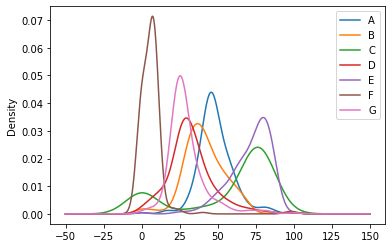

In [61]:
X_bases = X_int.apply(lambda x: gd.compress_int_array(x, deviation_bits=DEVIATION_BITS, output="integer"), axis = 1)
X_bases = pd.DataFrame(pd.DataFrame(X_bases)[0].to_list(), columns=COLUMNS)
X_bases.plot.density()

## Isolation Forest

In [62]:
rng = np.random.RandomState(42)

outliers = y.where(lambda x: x == -1).dropna()
outlier_indices = outliers.index
X_outliers = X_bases.filter(items=outlier_indices, axis=0)
X_outliers = np.array(X_outliers)

X = np.array(X_bases)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rng)

clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
dec_function = clf.decision_function(X_train)
pd.concat([pd.DataFrame(X_train),pd.DataFrame(dec_function)], axis=1)

,0,1,2,3,4,5,6,0
0,40,28,72,36,88,8,20,0.104487
1,48,40,76,32,80,8,20,0.138722
2,48,36,76,36,84,8,20,0.133477
3,64,60,84,16,52,0,36,0.018075
4,48,48,76,28,76,4,20,0.089762
...,...,...,...,...,...,...,...,...
138,48,36,76,44,84,8,24,0.124970
139,52,36,76,44,80,8,24,0.110759
140,56,36,76,16,68,0,40,0.045945
141,32,56,0,4,48,0,48,-0.036927


In [63]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.8028169014084507

In [64]:
confusion_matrix(y_test, y_pred_test, labels=[1,-1])

array([[57, 13],
       [ 1,  0]])